In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
#double iteration in pandas
from itertools import product
#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes

%matplotlib inline

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in

In [3]:
def remove_outliers_ja(fname_ja):
    
    #read the data files
    df4 = xr.open_dataset(fname_ja)
    
    #select all the required variables to detect only the valid data
    df4 = df4[['swh_ku','swh_rms_ku','surface_type','wind_speed_alt','ice_flag','sig0_ku','off_nadir_angle_wf_ku','sig0_rms_ku', \
               'range_rms_ku', 'swh_numval_ku', 'swh_rms_ku']]
    
    # convert to pandas dataframe
    df4 = df4.to_dataframe()
    df4.reset_index(inplace=True)
    
        # apply the filtering criteria
    df4 = df4[(df4['surface_type'] == 0.) & (df4['ice_flag'] == 0.) & (df4['swh_ku'] < 30.) & (df4['sig0_ku'] < 32.38) & \
            (df4['sig0_ku'] > 9.38) & (df4['wind_speed_alt'] > 0.) \
            & (df4['off_nadir_angle_wf_ku'] < 0.64) & (df4['off_nadir_angle_wf_ku'] > -0.2) & (df4['wind_speed_alt'] < 30) & \
             (df4['sig0_rms_ku'] < 2.5) & (df4['range_rms_ku'] < 0.0115*df4['swh_ku'] + 0.2) & (df4['swh_numval_ku'] > 10) & \
            (df4['swh_rms_ku'] < df4['swh_ku'])]
    
    # remove outliers from significant wave height
    q1 = df4['swh_ku'].quantile(0.25)
    q3 = df4['swh_ku'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed_ja = df4.loc[(df4['swh_ku'] > fence_low) & (df4['swh_ku'] < fence_high)]
    
    '''
    # remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    '''
    
    return outliers_removed_ja

In [4]:
# import all data files
pp = Path('C:/Users/panmits86/Desktop/J3_val')

results = []
for fname_ja in pp.glob('*.nc'):
    swh_ja = remove_outliers_ja(fname_ja)
    results.append(swh_ja)
    swh_j = pd.concat(results)

In [5]:
swh_ja = swh_j[['time','lon','lat','swh_ku','wind_speed_alt']]
swh_ja = swh_ja.reset_index()
swh_ja.drop(['index'], axis=1, inplace=True)
swh_ja

,time,lon,lat,swh_ku,wind_speed_alt
0,2016-06-27 06:18:09.679733056,286.740002,40.581447,1.100,1.88
1,2016-06-27 06:18:10.698442944,286.773812,40.535419,0.933,4.21
2,2016-06-27 06:18:11.717152128,286.807570,40.489377,1.061,4.89
3,2016-06-27 06:18:12.735862976,286.841276,40.443323,0.899,4.46
4,2016-06-27 06:18:13.754571904,286.874931,40.397256,1.003,4.53
...,...,...,...,...,...
9196,2016-06-24 21:37:29.572333120,289.082444,41.099596,0.796,4.22
9197,2016-06-24 21:37:30.591042048,289.116904,41.145459,0.535,4.13
9198,2016-06-24 21:37:31.609752896,289.151417,41.191308,0.882,3.38
9199,2016-06-24 21:37:44.852983936,289.605067,41.786108,0.909,3.03


In [6]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [7]:
# coordinates of buoy 44097
b44097 = (buoys['Latitude'][0],buoys['Longitude'][0]+360)
b44097

(40.969, 288.873)

In [8]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [9]:
#read all files since 2016 for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44097_1'
all_files = glob.glob(path + "/*.txt")

b44097_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,8,9], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44097_wave = b44097_wave[b44097_wave.WVHT !=99]
b44097_wave.reset_index(inplace=True)
b44097_wave.drop('index', 1, inplace=True)
b44097_wave

,Date,WVHT,DPD
0,2016-05-13 18:55:00,0.65,8.33
1,2016-05-13 19:25:00,0.62,9.09
2,2016-05-13 19:55:00,0.61,8.33
3,2016-05-13 20:55:00,0.58,9.09
4,2016-05-13 21:25:00,0.60,13.33
...,...,...,...
56422,2019-12-31 21:30:00,2.03,9.09
56423,2019-12-31 22:00:00,1.75,9.88
56424,2019-12-31 22:30:00,1.83,9.09
56425,2019-12-31 23:00:00,1.99,9.09


In [10]:
b44097_time = b44097_wave['Date']
b44097_time

0       2016-05-13 18:55:00
1       2016-05-13 19:25:00
2       2016-05-13 19:55:00
3       2016-05-13 20:55:00
4       2016-05-13 21:25:00
                ...        
56422   2019-12-31 21:30:00
56423   2019-12-31 22:00:00
56424   2019-12-31 22:30:00
56425   2019-12-31 23:00:00
56426   2019-12-31 23:30:00
Name: Date, Length: 56427, dtype: datetime64[ns]

In [11]:
a2 = [(swh_ja['lat'][m], swh_ja['lon'][m]) for m in range(swh_ja.shape[0])]

In [12]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav6 = haversine_vector([b44097]*swh_ja.shape[0],a2, Unit.KILOMETERS)
coloc_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
coloc_ja

,Buoy-Sat. Distance (km)
0,184.702313
1,183.273909
2,182.023652
3,180.955189
4,180.071728
...,...
9196,22.792332
9197,28.341234
9198,33.994667
9199,109.480602


In [13]:
swh_ja['Buoy-Sat. Distance (km)'] = coloc_ja
swh_ja

,time,lon,lat,swh_ku,wind_speed_alt,Buoy-Sat. Distance (km)
0,2016-06-27 06:18:09.679733056,286.740002,40.581447,1.100,1.88,184.702313
1,2016-06-27 06:18:10.698442944,286.773812,40.535419,0.933,4.21,183.273909
2,2016-06-27 06:18:11.717152128,286.807570,40.489377,1.061,4.89,182.023652
3,2016-06-27 06:18:12.735862976,286.841276,40.443323,0.899,4.46,180.955189
4,2016-06-27 06:18:13.754571904,286.874931,40.397256,1.003,4.53,180.071728
...,...,...,...,...,...,...
9196,2016-06-24 21:37:29.572333120,289.082444,41.099596,0.796,4.22,22.792332
9197,2016-06-24 21:37:30.591042048,289.116904,41.145459,0.535,4.13,28.341234
9198,2016-06-24 21:37:31.609752896,289.151417,41.191308,0.882,3.38,33.994667
9199,2016-06-24 21:37:44.852983936,289.605067,41.786108,0.909,3.03,109.480602


In [14]:
#dist_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
radius_ja = swh_ja['Buoy-Sat. Distance (km)'] < 15.
colocated_ja = swh_ja[radius_ja]
colocated_ja.reset_index(inplace=True)
colocated_ja.drop('index', 1, inplace=True)
colocated_ja

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lon,lat,swh_ku,wind_speed_alt,Buoy-Sat. Distance (km)
0,2016-07-04 19:35:57.729774016,288.941950,40.916233,0.729,4.87,8.244156
1,2016-07-04 19:35:58.748482944,288.976194,40.962150,0.700,5.22,8.697976
2,2016-07-04 19:35:59.767193088,289.010492,41.008054,0.757,5.38,12.330352
3,2016-07-14 17:34:28.959646912,288.905543,40.869404,0.936,6.97,11.407152
4,2016-07-14 17:34:29.978358016,288.939734,40.915336,1.000,7.47,8.186924
...,...,...,...,...,...,...
528,2016-06-14 23:38:55.331578048,289.017445,41.007084,1.096,4.90,12.842313
529,2016-06-24 21:37:24.478782912,288.910947,40.870084,0.957,4.79,11.451780
530,2016-06-24 21:37:25.497493056,288.945140,40.916013,1.074,5.11,8.451574
531,2016-06-24 21:37:26.516202944,288.979386,40.961928,0.906,4.63,8.967135


In [15]:
sat_time_ja = colocated_ja['time'].reset_index()
sat_time_ja.drop('index', 1, inplace=True)

In [16]:
#time difference in minutes
diff_ja = [(b44097_time[d], b44097_wave['WVHT'][d], sat_time_ja['time'][s], colocated_ja['swh_ku'][s],  \
         colocated_ja['Buoy-Sat. Distance (km)'][s], (sat_time_ja['time'][s] - b44097_time[d]).total_seconds() / 60) \
           for d, s in product(range(b44097_time.shape[0]), range(sat_time_ja.shape[0]))]

In [17]:
t_ja = pd.DataFrame(list(diff_ja))
t_ja.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'Jason 3 Time', 'Jason 3 Wave Height', 'Buoy-Sat. Distance (km)', \
                'Time Difference (min.)']
#t_ja

In [20]:
final_ja = abs(t_ja['Time Difference (min.)']) < 15.
final_ja = t_ja[final_ja]
final_ja = final_ja.set_index('Buoy 44097 Time')
final_ja

,Buoy 44097 Wave Height,Jason 3 Time,Jason 3 Wave Height,Buoy-Sat. Distance (km),Time Difference (min.)
Buoy 44097 Time,,,,,
2016-05-16 05:55:00,1.76,2016-05-16 05:43:15.941915968,1.950,11.660648,-11.734301
2016-05-16 05:55:00,1.76,2016-05-16 05:43:16.960627072,1.800,8.816358,-11.717323
2016-05-16 05:55:00,1.76,2016-05-16 05:43:17.979336000,1.798,9.390861,-11.700344
2016-05-16 05:55:00,1.76,2016-05-16 05:43:18.998047104,1.833,12.936199,-11.683366
2016-05-26 03:55:00,1.04,2016-05-26 03:41:47.000933888,0.812,14.784482,-13.216651
...,...,...,...,...,...
2019-12-16 02:30:00,3.80,2019-12-16 02:28:45.905746944,3.687,13.123683,-1.234904
2019-12-26 00:30:00,0.70,2019-12-26 00:27:14.792397056,0.739,11.633996,-2.753460
2019-12-26 00:30:00,0.70,2019-12-26 00:27:15.811104768,0.507,8.822463,-2.736482


In [21]:
df2 = final_ja.iloc[:,[0,2]]
#df2.reset_index(inplace=True)
#df2.drop('index', 1, inplace=True)
df2 = df2.resample('D').mean()
df2 = df2.dropna()
df2

,Buoy 44097 Wave Height,Jason 3 Wave Height
Buoy 44097 Time,,
2016-05-16,1.76,1.845250
2016-05-26,1.04,1.022800
2016-06-05,0.78,0.691667
2016-06-14,0.94,0.909750
2016-07-04,0.77,0.728667
...,...,...
2019-11-16,1.86,1.816000
2019-11-26,1.16,1.158000
2019-12-06,2.60,2.508250


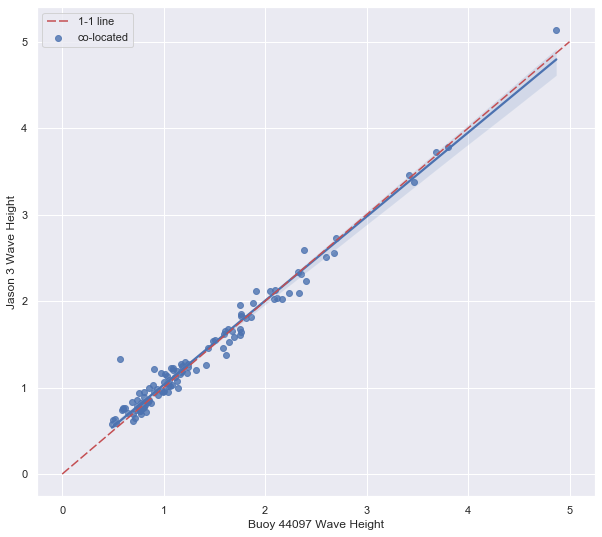

In [28]:
import seaborn as sns; sns.set(color_codes=True)
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='Jason 3 Wave Height', data=df2, label='co-located')
line2 = plt.plot([0, 5], [0, 5], dashes=[6, 2], color='r', label='1-1 line')
ax.legend()

In [24]:
#correlation coefficient and p-value (statistical significance)
scipy.stats.pearsonr(df2['Buoy 44097 Wave Height'], df2['Jason 3 Wave Height'])

(0.9870816789016159, 1.0287713759260922e-91)

In [25]:
scipy.stats.spearmanr(df2['Buoy 44097 Wave Height'], df2['Jason 3 Wave Height'])

SpearmanrResult(correlation=0.9554968988876181, pvalue=9.636736041908717e-62)

In [27]:
# root mean squared error (m)
sqrt(mean_squared_error(df2['Buoy 44097 Wave Height'], df2['Jason 3 Wave Height']))

0.12483697302894513